<a href="https://colab.research.google.com/github/HarshitCodex/ClassificationDL/blob/master/Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

## Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012

In [0]:
??URL.PETS

Object `URL.PETS` not found.


In [0]:
path=untar_data(URLs.PETS);path #URLs.PETS contains the aws link to the dataset

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
!ls {path}

annotations  images


In [0]:
path_anno=path/'annotations'
path_img=path/'images'

In [0]:
fnames=get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/boxer_151.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_186.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_31.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_158.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_32.jpg')]

In [0]:
np.random.seed(2)
pat=r'/([^/]+)_\d+.jpg$'

In [0]:
data=ImageDataBunch.from_name_re(path_img,fnames,pat,ds_tfms=get_transforms(),size=224)

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
boxer,scottish_terrier,Abyssinian,havanese,german_shorthaired
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,wheaten_terrier,scottish_terrier,yorkshire_terrier,japanese_chin
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

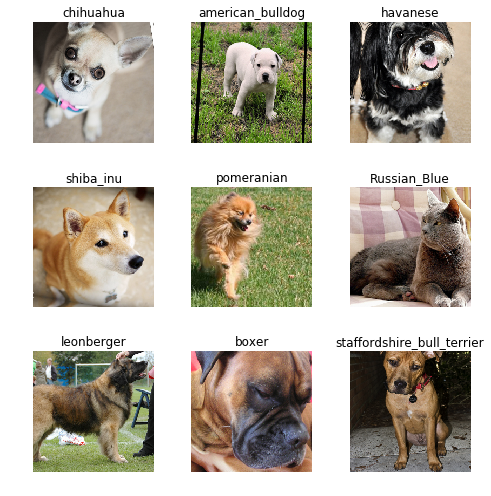

In [0]:
data.show_batch(rows=3,figsize=(7,7))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [0]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate)#transfer learning using resnet34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27586842.93it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.374420,0.329096,0.096076,01:50
1,0.543312,0.254524,0.080514,01:51
2,0.337527,0.225386,0.071719,01:45
3,0.258774,0.219870,0.074425,01:46


In [0]:
learn.save('stage-1')

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

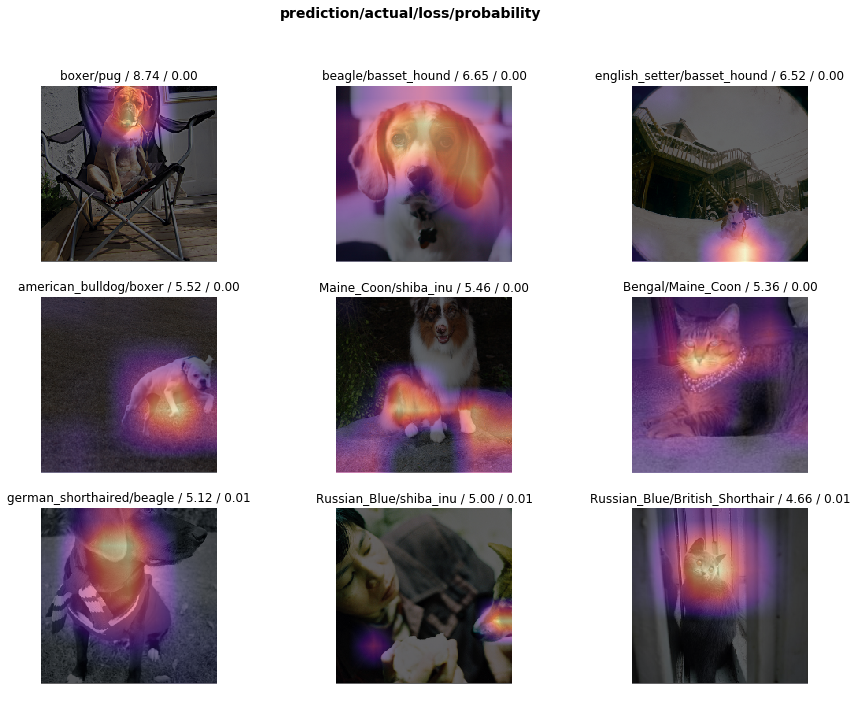

In [0]:
interp.plot_top_losses(9,figsize=(15,11))

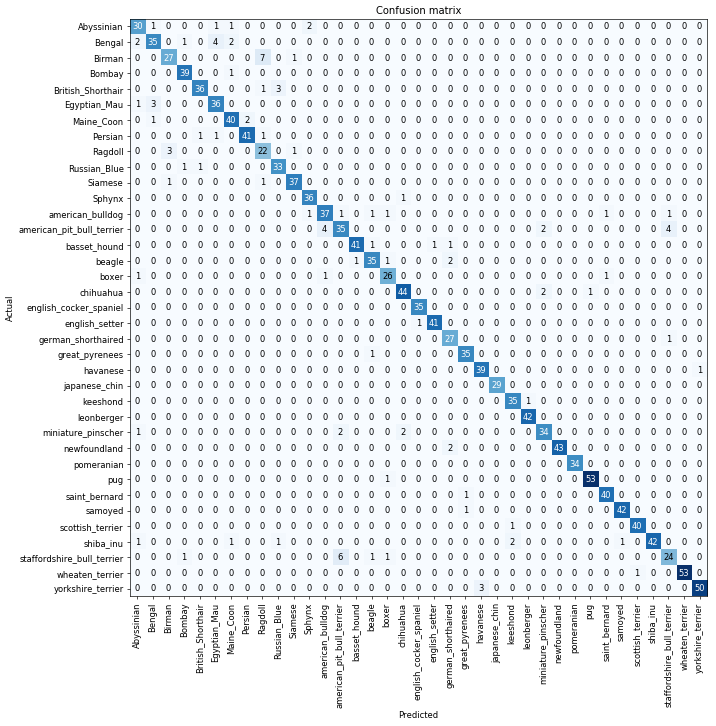

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [0]:
interp.most_confused(min_val=4)

[('Birman', 'Ragdoll', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4)]

## FINE TUNING MY MODEL, UNFREEZING, Learning Rates

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.518632,0.301541,0.096076,01:58


In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
boxer,scottish_terrier,Abyssinian,havanese,german_shorthaired
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,wheaten_terrier,scottish_terrier,yorkshire_terrier,japanese_chin
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kern

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


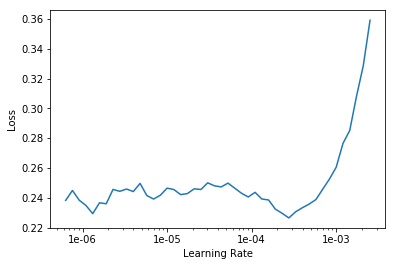

In [0]:
learn.recorder.plot()

Looks like my default learning rate of 0.003 wasnt actually good enough so i think i should go for somewhere close to 1e-5

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.230030,0.208446,0.071042,02:05
1,0.190583,0.198143,0.064953,01:59


So yeah! I got a model that has only 6% error in determining the breed. Let me try with a resnet 50 (50 layers, so will have to use batch size of probably 48 for a fast model)

##RESNET50

In [0]:
data=ImageDataBunch.from_name_re(path_img,fnames,pat,ds_tfms=get_transforms(),size=299,bs=48)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
boxer,scottish_terrier,Abyssinian,Abyssinian,havanese
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
British_Shorthair,samoyed,miniature_pinscher,Birman,Abyssinian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [0]:
learn=cnn_learner(data,models.resnet50,metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


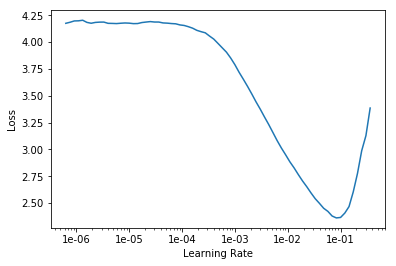

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.921992,0.292430,0.087280,03:26
1,0.398458,0.240568,0.074425,03:22
2,0.293134,0.275029,0.088633,03:24
3,0.207282,0.196813,0.063599,03:26
4,0.189829,0.196908,0.060893,03:28
5,0.131774,0.191305,0.058187,03:22
6,0.094751,0.187023,0.054804,03:21
7,0.082737,0.185513,0.056157,03:21


That is quite an improvement from the resnet 34 model to resnet50 model but the time taken is huge.

I can't even increase the batch size because colab only has a 12GB gpu and i received 2 warnings already :D.

In [0]:
learn.save('stage-2')

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

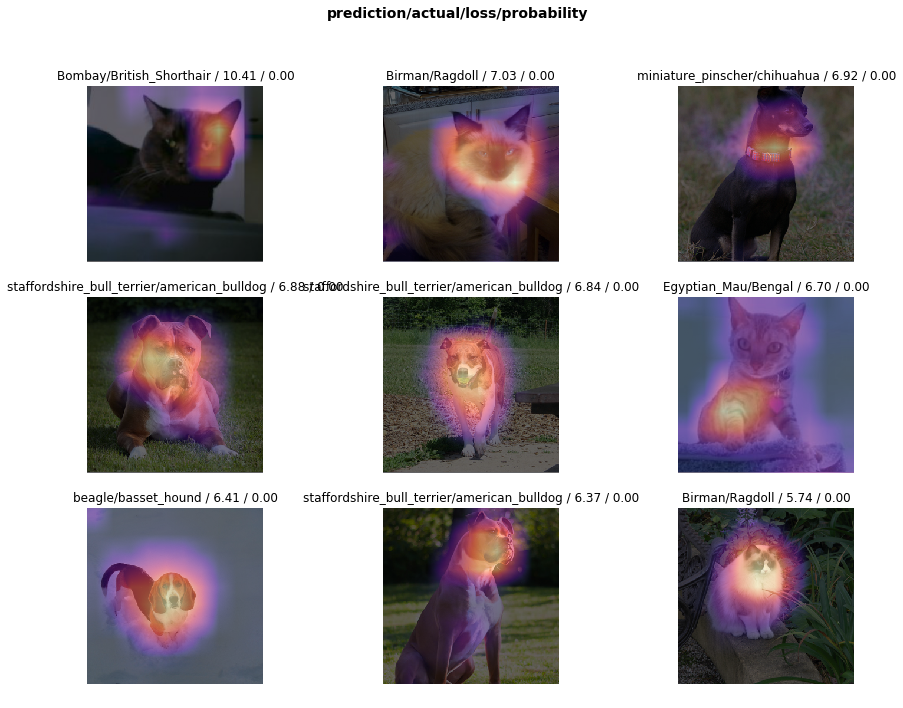

In [0]:
interp.plot_top_losses(9,figsize=(15,11))